In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import os

In [3]:
def load_dataset(data_dir="dataset_small", solution_file="solution.csv"):
    df_w = pd.read_csv(os.path.join(data_dir, "warehouses.csv"))
    df_c = pd.read_csv(os.path.join(data_dir, "customers.csv"))
    df_cost = pd.read_csv(os.path.join(data_dir, "cost_params.csv"))
    return df_w, df_c, df_cost

In [4]:
def solve_convex_transport(df_w, df_c, df_cost):
    m = df_w.shape[0]
    n = df_c.shape[0]

    warehouse_ids = df_w["id"].to_numpy()
    customer_ids = df_c["id"].to_numpy()

    id_to_w_idx = {wid: idx for idx, wid in enumerate(warehouse_ids)}
    id_to_c_idx = {cid: idx for idx, cid in enumerate(customer_ids)}

    S = df_w["supply"].to_numpy()
    D = df_c["demand"].to_numpy()

    edges_i = df_cost["i"].to_numpy(dtype=int)
    edges_j = df_cost["j"].to_numpy(dtype=int)
    a_ij = df_cost["a_ij"].to_numpy()
    b_ij = df_cost["b_ij"].to_numpy()

    num_edges = len(a_ij)

    print(f"Số kho = {m}, số khách = {n}, số tuyến = {num_edges}")
    print(f"Tổng cung  = {S.sum():.4f}")
    print(f"Tổng cầu   = {D.sum():.4f}")

    # Biến quyết định
    x = cp.Variable(num_edges, nonneg=True)

    # Ràng buộc
    constraints = []

    # Supply constraints
    for wid in warehouse_ids:
        w_idx = id_to_w_idx[wid]
        idx_edges = np.where(edges_i == wid)[0]
        constraints.append(cp.sum(x[idx_edges]) <= S[w_idx])

    # Demand constraints
    for cid in customer_ids:
        c_idx = id_to_c_idx[cid]
        idx_edges = np.where(edges_j == cid)[0]
        constraints.append(cp.sum(x[idx_edges]) == D[c_idx])

    # Objective function
    quad_term = cp.multiply(a_ij, cp.square(x))
    lin_term = cp.multiply(b_ij, x)
    objective = cp.Minimize(cp.sum(quad_term + lin_term))

    prob = cp.Problem(objective, constraints)

    print("Đang giải bài toán tối ưu...")
    prob.solve(solver=cp.OSQP, verbose=False)

    print(f"Status: {prob.status}")
    print(f"Optimal Cost Z* = {prob.value:.4f}")

    x_opt = x.value
    df_sol = df_cost.copy()
    df_sol["x_ij"] = x_opt

    return df_sol

In [5]:
def plot_heatmap(df_w, df_c, df_sol):
    m = df_w.shape[0]
    n = df_c.shape[0]

    heat = np.zeros((m, n))

    for _, row in df_sol.iterrows():
        heat[int(row["i"]) - 1][int(row["j"]) - 1] = row["x_ij"]

    plt.figure(figsize=(14, 8))
    sns.heatmap(
        heat, cmap="Blues", linewidths=0.1, linecolor="gray"
    )
    plt.title("Heatmap phân bố hàng x_ij")
    plt.xlabel("Customer")
    plt.ylabel("Warehouse")
    plt.show()


In [6]:
def plot_used_routes(df_w, df_c, df_sol, threshold=1e-6):
    plt.figure(figsize=(12, 10))

    plt.scatter(df_c["x"], df_c["y"], c="red", label="Customers", s=50)
    plt.scatter(df_w["x"], df_w["y"], c="blue", label="Warehouses", s=80)

    for _, r in df_w.iterrows():
        plt.text(r["x"] + 0.3, r["y"] + 0.3, f"W{int(r['id'])}", color="blue")

    for _, r in df_c.iterrows():
        plt.text(r["x"] + 0.3, r["y"] + 0.3, f"C{int(r['id'])}", color="red")

    max_flow = df_sol["x_ij"].max()

    for _, row in df_sol.iterrows():
        if row["x_ij"] > threshold:
            wi = df_w.iloc[int(row["i"]) - 1]
            cj = df_c.iloc[int(row["j"]) - 1]
            lw = max(0.3, row["x_ij"] / max_flow * 3)
            plt.plot([wi["x"], cj["x"]], [wi["y"], cj["y"]], "gray", linewidth=lw, alpha=0.6)

    plt.title("Các tuyến vận tải được sử dụng (x_ij > 0)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
def compute_warehouse_load(df_w, df_sol):
    load = np.zeros(df_w.shape[0])

    for _, r in df_sol.iterrows():
        load[int(r["i"]) - 1] += r["x_ij"]

    df_res = df_w.copy()
    df_res["load"] = load
    df_res["utilization"] = load / df_res["supply"]

    print(df_res[["id", "supply", "load", "utilization"]])

    plt.figure(figsize=(12, 5))
    sns.barplot(x=df_res["id"], y=df_res["load"], color="blue")
    plt.title("Tải của từng kho")
    plt.xlabel("Warehouse ID")
    plt.ylabel("Load xuất")
    plt.show()

    return df_res


In [8]:
def compute_customer_sources(df_c, df_sol, threshold=1e-6):
    count = np.zeros(df_c.shape[0], dtype=int)

    for _, r in df_sol.iterrows():
        if r["x_ij"] > threshold:
            count[int(r["j"]) - 1] += 1

    df_src = df_c.copy()
    df_src["num_sources"] = count

    print(df_src[["id", "num_sources"]])

    plt.figure(figsize=(12, 6))
    sns.countplot(x=df_src["num_sources"])
    plt.title("Phân phối: Khách nhận từ bao nhiêu kho")
    plt.xlabel("Số kho")
    plt.ylabel("Số khách")
    plt.show()

    return df_src


Số kho = 60, số khách = 150, số tuyến = 4151
Tổng cung  = 4697.6972
Tổng cầu   = 4697.6972
Đang giải bài toán tối ưu...
Status: optimal
Optimal Cost Z* = 51340.3168


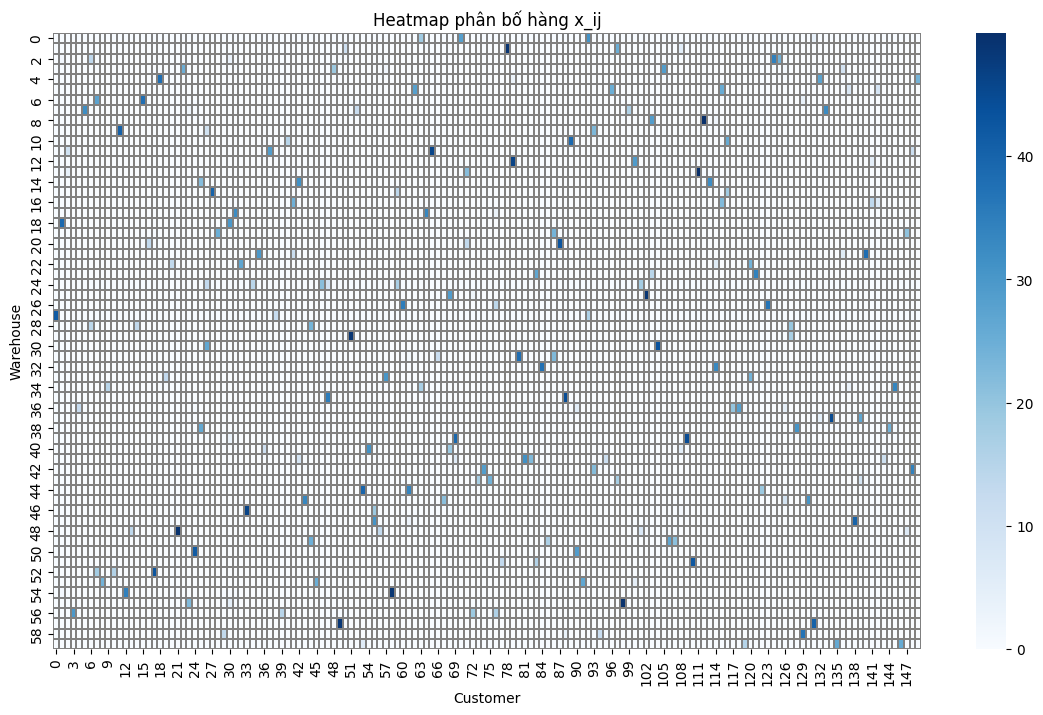

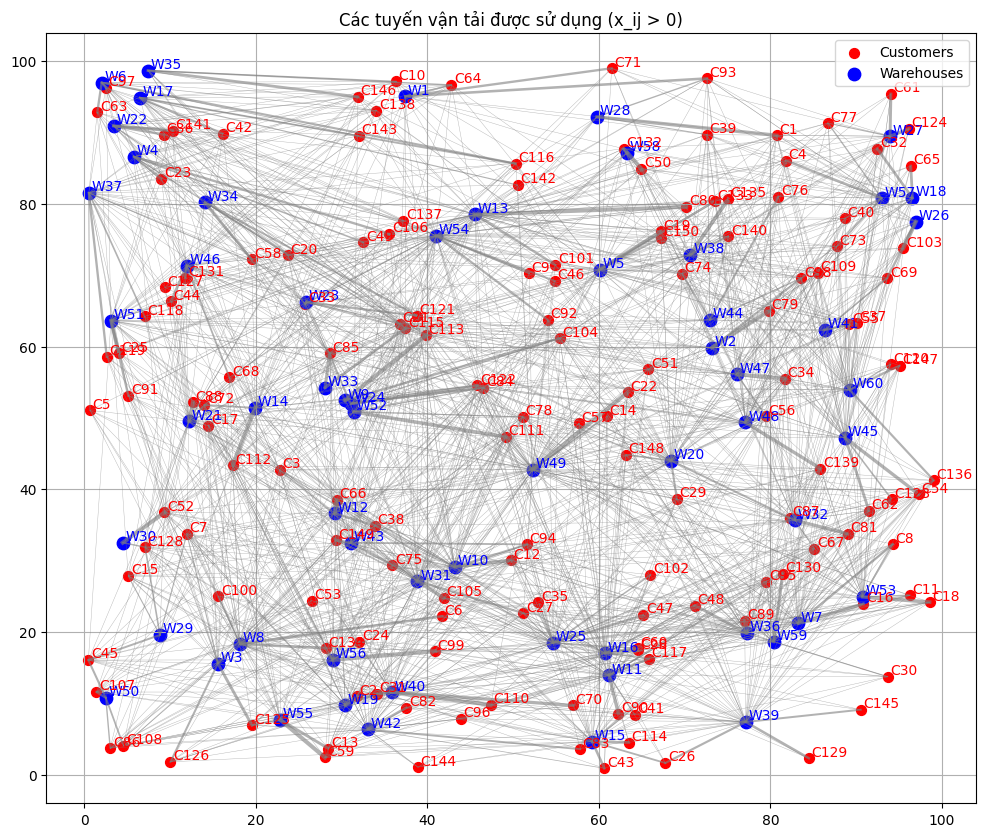

    id     supply       load  utilization
0    1  81.251064  81.251979     1.000011
1    2  89.966473  89.969656     1.000035
2    3  77.455236  77.456444     1.000016
3    4  84.744719  84.744876     1.000002
4    5  92.510369  92.511479     1.000012
5    6  95.327243  95.327424     1.000002
6    7  69.392495  69.393065     1.000008
7    8  94.586059  94.586326     1.000003
8    9  80.544131  80.547948     1.000047
9   10  72.985492  72.987415     1.000026
10  11  79.478214  79.478057     0.999998
11  12  96.313377  96.316842     1.000036
12  13  80.560349  80.560712     1.000005
13  14  75.264255  75.265741     1.000020
14  15  85.110388  85.110745     1.000004
15  16  72.400547  72.400509     0.999999
16  17  67.091014  67.091117     1.000002
17  18  68.804481  68.805311     1.000012
18  19  68.777530  68.778840     1.000019
19  20  69.548573  69.549827     1.000018
20  21  69.125978  69.126918     1.000014
21  22  85.351941  85.352060     1.000001
22  23  70.517430  70.519729     1

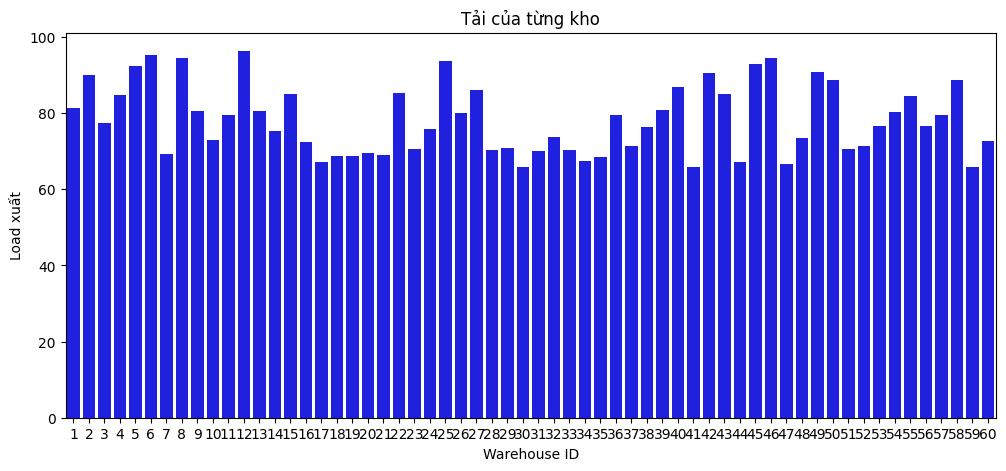

      id  num_sources
0      1           17
1      2           17
2      3           25
3      4           12
4      5            9
..   ...          ...
145  146           15
146  147           10
147  148           13
148  149           25
149  150            7

[150 rows x 2 columns]


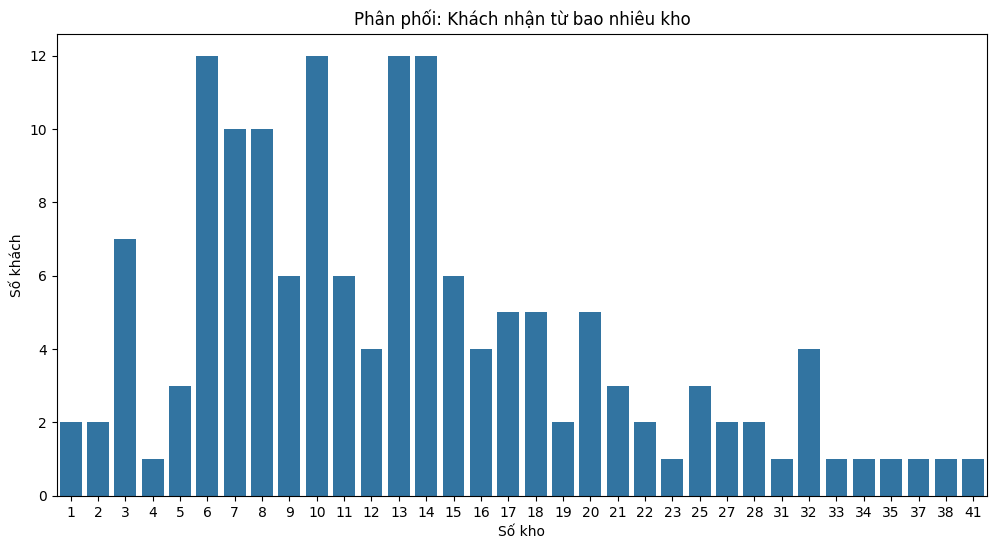

,id,x,y,demand,num_sources
0,1,80.744016,89.609130,41.663162,17
1,2,31.800347,11.005192,41.584726,17
2,3,22.793516,42.710779,13.648244,25
3,4,81.801477,86.073058,29.776812,12
4,5,0.695213,51.074730,12.302350,9
...,...,...,...,...,...
145,146,31.931364,95.006197,33.596707,15
146,147,95.060715,57.343789,25.689762,10
147,148,63.183721,44.844552,27.498997,13
148,149,29.321077,32.866455,46.166348,25


In [9]:
DATA_DIR = "dataset_large"   # đổi theo dataset của bạn
SOLUTION_NAME = "solution.csv"

df_w, df_c, df_cost = load_dataset(DATA_DIR)

# Solve
df_sol = solve_convex_transport(df_w, df_c, df_cost)

# Save solution
df_sol.to_csv(os.path.join(DATA_DIR, SOLUTION_NAME), index=False)

# Visualization
plot_heatmap(df_w, df_c, df_sol)
plot_used_routes(df_w, df_c, df_sol)

# Analytics
compute_warehouse_load(df_w, df_sol)
compute_customer_sources(df_c, df_sol)
